In [1]:
import os
import torch
import itertools
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from typing import List, Tuple, Dict
from tqdm import tqdm
import random
from scipy.linalg import sqrtm

In [2]:
# Decide which device we want to run on
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [9]:
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_TEST = 1

# Define the Transform class
class Transform():
    def __init__(self):
        self.data_transform = transforms.Compose([transforms.ToTensor()])

    def __call__(self, inp):
        return self.data_transform(inp)

# Define the SeismicDataset class
class SeismicDataset(Dataset):
    def __init__(self, elastic_patches, acoustic_patches):
        self.elastic_patches = elastic_patches
        self.acoustic_patches = acoustic_patches
        self.trasformer = Transform()

    def __len__(self):
        return len(self.elastic_patches)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        elastic_patch = self.elastic_patches[idx]
        acoustic_patch = self.acoustic_patches[idx]
        elastic_patch  = self.trasformer(elastic_patch)
        acoustic_patch = self.trasformer(acoustic_patch)
        return elastic_patch, acoustic_patch

# Function to load binary data
def load_bin_data(file, samples):
    data = np.fromfile(file, dtype='float32')
    nrecs = data.size // samples
    data = data.reshape(nrecs, samples).T
    return data

def preprocess_patches(patches):
    # Normalize and add channel dimension for grayscale images
    max = abs(np.max(patches))
    min = abs(np.min(patches))
    maxi = np.max([max, min])
    patches = patches/maxi  # Normalize to [-1, 1]
    return patches[..., np.newaxis]  # Add channel dimension

# Function to split data into patches
def split_into_patches(data, patch_size=256, vertical_overlap=0, horizontal_overlap=0):
    step_h = patch_size - horizontal_overlap
    step_v = patch_size - vertical_overlap
    patches = []
    for i in range(0, data.shape[0] - patch_size + 1, step_v):
        for j in range(0, data.shape[1] - patch_size + 1, step_h):
            patch = data[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return np.array(patches)

# Function to remove all-zero patches and maintain pairing
def remove_zero_and_same_value_patches(elastic_patches, acoustic_patches):
    paired_patches = []
    for e_patch, a_patch in zip(elastic_patches, acoustic_patches):
        if not np.all(e_patch <= 1e-4) and not np.all(a_patch <= 1e-4) and \
           len(np.unique(e_patch)) > 1 and len(np.unique(a_patch)) > 1:
            paired_patches.append((e_patch, a_patch))
    
    # Unzip the list of tuples back into separate arrays
    elastic_patches, acoustic_patches = zip(*paired_patches)
    return np.array(elastic_patches), np.array(acoustic_patches)

# Function to process folder
def process_folder(data_dir_elastic, data_dir_acoustic, idx_train, samples=768, patch_size=256):
    all_data_train_elastic = []
    all_data_test_elastic = []
    all_data_train_acoustic = []
    all_data_test_acoustic = []

    # Combine elasticdata and acousticdata based on idx_train
    for idx in range(1,362):
        elastic_file = f"Elasticdata{idx}.bin"
        if idx in idx_train:
            data = load_bin_data(os.path.join(data_dir_elastic, elastic_file), samples)
            all_data_train_elastic.append(data)
        else:
            data = load_bin_data(os.path.join(data_dir_elastic, elastic_file), samples)
            all_data_test_elastic.append(data)

    for idx in range(1,362):
        acoustic_file = f"Acusticdata{idx}.bin"
        if idx in idx_train:
            data = load_bin_data(os.path.join(data_dir_acoustic, acoustic_file), samples)
            all_data_train_acoustic.append(data)
        else:
            data = load_bin_data(os.path.join(data_dir_acoustic, acoustic_file), samples)
            all_data_test_acoustic.append(data)

    print(f'Train seismograms length : {len(all_data_train_elastic)}')
    print(f'Train seismograms length : {len(all_data_train_acoustic)}')

    return np.array(all_data_train_elastic), np.array(all_data_test_elastic), np.array(all_data_train_acoustic), np.array(all_data_test_acoustic)

# Paths to the directories
elastic_dir = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data\Elastic_data\Vzfield'
acoustic_dir = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data\Acustic_data\Pfield'

# 80% of the files are used for training
n_train = 300
idx_train = np.sort(random.sample(range(1, 361), n_train))

# Load and separate data
train_elastic, test_elastic, train_acoustic, test_acoustic = process_folder(elastic_dir, acoustic_dir, idx_train)

# Split training data into patches
vertical_overlap = 128 # five vertical windowns
horizontal_overlap = 151 # two horizontal windowns
patch_size = 256
train_elastic_patches = np.concatenate([split_into_patches(data, patch_size, vertical_overlap, horizontal_overlap ) for data in train_elastic])
train_acoustic_patches = np.concatenate([split_into_patches(data, patch_size, vertical_overlap, horizontal_overlap ) for data in train_acoustic])

# Preprocess and create datasets
test_elastic_patches = preprocess_patches(test_elastic)
test_acoustic_patches = preprocess_patches(test_acoustic)
train_elastic_patches = preprocess_patches(train_elastic_patches)
train_acoustic_patches = preprocess_patches(train_acoustic_patches)

# # Remove zero patches and maintain pairing
# train_elastic_patches, train_acoustic_patches = remove_zero_and_same_value_patches(train_elastic_patches, train_acoustic_patches)
# test_elastic_patches, test_acoustic_patches = remove_zero_and_same_value_patches(test_elastic_patches, test_acoustic_patches)

# Create the dataset with paired data
test_ds = SeismicDataset(test_acoustic_patches, test_elastic_patches)
train_ds = SeismicDataset(train_acoustic_patches, train_elastic_patches)

# Create the DataLoader with the desired parameters
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE_TEST, shuffle=True, drop_last=True)

Train seismograms length : 300
Train seismograms length : 300


In [10]:
# Número total de patches no dataset de treino
num_train_patches = len(train_ds)
num_test_patches = len(test_ds)

# Número de batches no DataLoader
num_train_batches = len(train_dl)
num_test_batches = len(test_dl)

print(f"Número total de patches de treino: {num_train_patches}")
print(f"Número total de patches de teste: {num_test_patches}")
print(f"Número total de batches de treino: {num_train_batches}")
print(f"Número total de batches de teste: {num_test_batches}")

Número total de patches de treino: 3000
Número total de patches de teste: 61
Número total de batches de treino: 750
Número total de batches de teste: 61


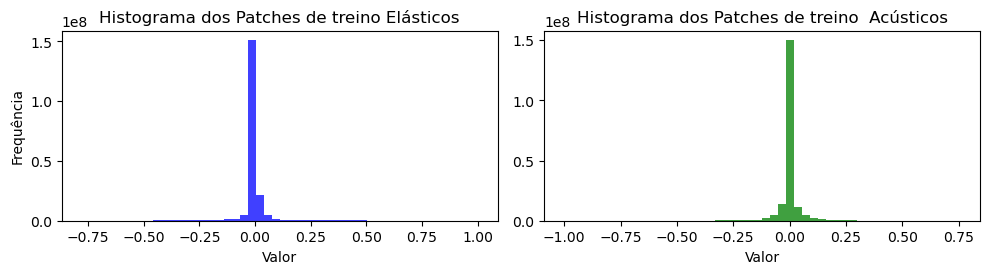

In [13]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in train_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de treino Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de treino  Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

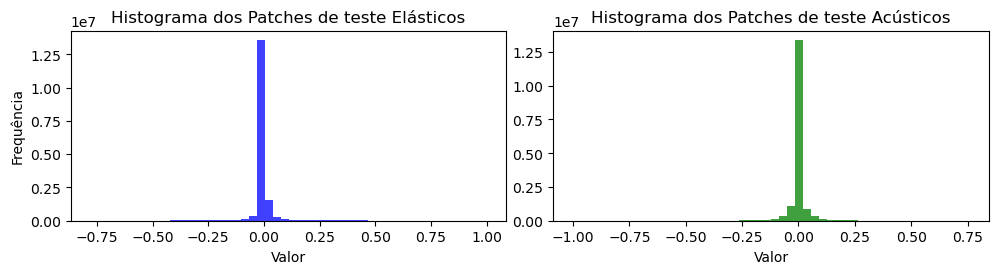

In [14]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in test_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de teste Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de teste Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

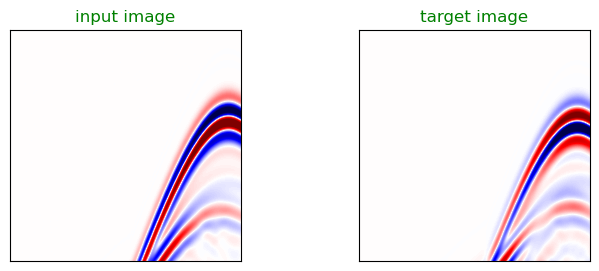

In [15]:
def show_img_sample(train_dl):
    for i, (real_input, real_target) in enumerate(train_dl):
        if i > 0:
            break
        fig, axes = plt.subplots(1, 2, figsize=(9, 3))
        ax = axes.ravel()
        
        perc = 99
        vmax = np.percentile(np.abs(real_input[0].squeeze()), perc)
        vmin = -vmax
        
        ax[0].imshow(real_input[0].squeeze(), cmap='seismic', vmin=vmin, vmax=vmax)
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title("input image", c="g")
        ax[1].imshow(real_target[0].squeeze(), cmap='seismic', vmin=vmin, vmax=vmax)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title("target image", c="g")
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

show_img_sample(train_dl)

In [19]:
class GeneratorUnet(nn.Module):
    def __init__(self, in_channels):
        super(GeneratorUnet, self).__init__()
        self.down_stack = nn.ModuleList([
            self.Downsample(in_channels, 64, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
            self.Downsample(64, 128),  # (batch_size, 64, 64, 128)
            self.Downsample(128, 256),  # (batch_size, 32, 32, 256)
            self.Downsample(256, 512),  # (batch_size, 16, 16, 512)
            self.Downsample(512, 512),  # (batch_size, 8, 8, 512)
            self.Downsample(512, 512),  # (batch_size, 4, 4, 512)
            self.Downsample(512, 512),  # (batch_size, 2, 2, 512)
            self.Downsample(512, 512, apply_batchnorm=False),  # (batch_size, 1, 1, 512)
        ])

        self.up_stack = nn.ModuleList([
            self.Upsample(512, 512, apply_dropout=True),  # (batch_size, 2, 2, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 4, 4, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 8, 8, 1024)
            self.Upsample(1024, 512),  # (batch_size, 16, 16, 1024)
            self.Upsample(1024, 256),  # (batch_size, 32, 32, 512)
            self.Upsample(512, 128),  # (batch_size, 64, 64, 256)
            self.Upsample(256, 64),  # (batch_size, 128, 128, 128)
        ])

        self.last = nn.ConvTranspose2d(128, in_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def Downsample(self, in_channels, out_channels, apply_batchnorm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))

        return nn.Sequential(*layers)

    def Upsample(self, in_channels, out_channels, apply_dropout=False):
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))

        return nn.Sequential(*layers)

    def forward(self, x):
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])
        
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)

        x = self.last(x)
        x = self.tanh(x)
        return x

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32     
            nn.ZeroPad2d(1), # padding left and top   256*32*32 -> 256*34*34
            nn.Conv2d(256, 512, 4, stride=1, bias=False), #256*34*34 -> 512*31*31
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d(1), #512*31*31 -> 512*33*33
            nn.Conv2d(512, 1, 4) #512*33*33 -> 1*30*30
        )
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, input, target):
        x = torch.cat((input, target), dim=1)
        return self.model(x)

In [23]:
criterion_L1  = nn.L1Loss() # Perda L1
criterion_GAN = nn.BCEWithLogitsLoss() # Perda quadrática

In [25]:
G = GeneratorUnet(1)
D = Discriminator(2)

In [27]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')

if cuda:
    G = G.cuda()
    D = D.cuda()
    
    criterion_L1 = criterion_L1.cuda()
    criterion_GAN = criterion_GAN.cuda()

cuda: True


In [29]:
def visualize_data(generator, discriminator, dataloader, title, device):
    generator.eval()  # Coloca o gerador no modo de avaliação
    discriminator.eval()  # Coloca o discriminador no modo de avaliação

    # Itera através do dataloader
    for i, (real_input, real_target) in enumerate(dataloader):
        if i > 0:
          break

        real_input, real_target = real_input.to(device), real_target.to(device)

        # Gera imagens falsas com o gerador
        with torch.no_grad():
            fake_image = generator(real_input)

        # Avalia as imagens reais e falsas com o discriminador
        real_output = discriminator(real_input,real_target)
        fake_output = discriminator(real_input,fake_image.detach())

        print(f'shape da saída do gerador {fake_image.shape}')
        print(f'shape da saída do discriminador {fake_output.shape}')

        # Visualiza os resultados
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'{title}')

        # Converte os tensores de volta para imagens no intervalo [0, 1]
        real_input_img = (real_input[0].cpu().permute(1, 2, 0) + 1) / 2
        real_target_img = (real_target[0].cpu().permute(1, 2, 0) + 1) / 2
        fake_image_img = (fake_image[0].cpu().permute(1, 2, 0) + 1) / 2

       # Mostra a imagem de entrada (real)
        im1 = ax[0].imshow(real_input_img, cmap='seismic')
        ax[0].set_title('Real Input')
        ax[0].axis('off')

        # Mostra a imagem real alvo (ground truth)
        im2 = ax[1].imshow(real_target_img, cmap='seismic')
        ax[1].set_title('Real Target')
        ax[1].axis('off')

        # Mostra a imagem falsa gerada
        im3 = ax[2].imshow(fake_image_img, cmap='seismic')
        ax[2].set_title('Generated Image')
        ax[2].axis('off')

       # # Desconecta os tensores e converte para numpy antes de exibir
       #  real_output_img = real_output[0, 0].detach().cpu().numpy()
       #  fake_output_img = fake_output[0, 0].detach().cpu().numpy()

       #  # Mostra o resultado do discriminador para a imagem real
       #  im1 = ax[1, 0].imshow(real_output_img, cmap='RdBu_r')
       #  ax[1, 0].set_title('Discriminator Output (Real Target)')
       #  ax[1, 0].axis('off')

       #  # Mostra o resultado do discriminador para a imagem gerada
       #  im2 = ax[1, 1].imshow(fake_output_img, cmap='RdBu_r')
       #  ax[1, 1].set_title('Discriminator Output (Generated Image)')
       #  ax[1, 1].axis('off')

        plt.tight_layout()
        plt.show()

shape da saída do gerador torch.Size([4, 1, 256, 256])
shape da saída do discriminador torch.Size([4, 1, 30, 30])


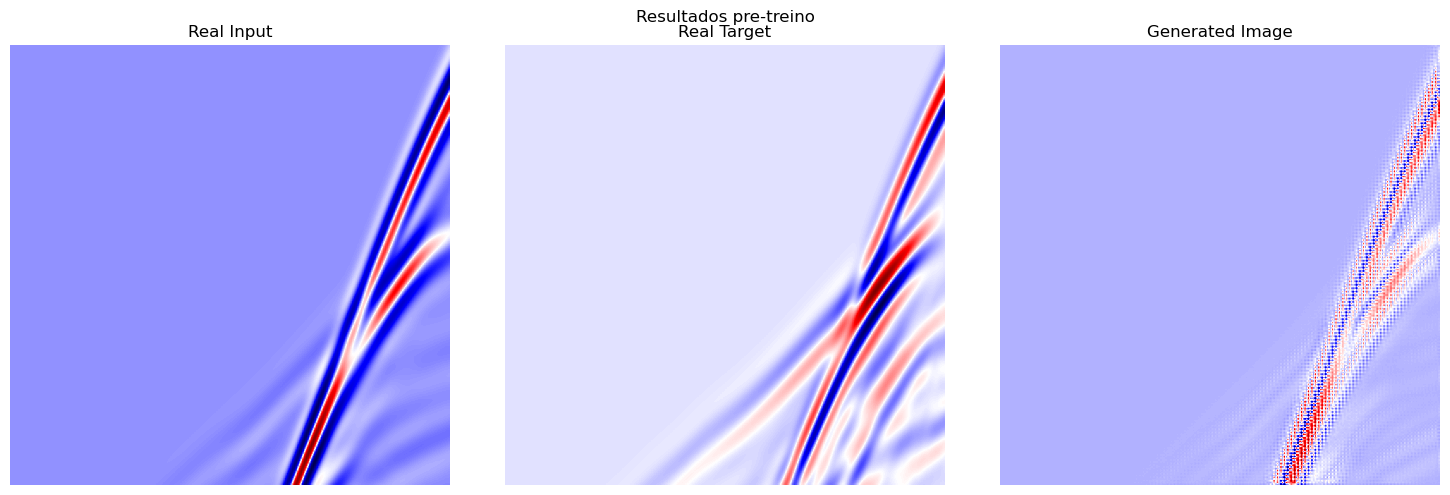

In [31]:
visualize_data(G, D, train_dl, 'Resultados pre-treino', device)

In [33]:
lr_G = 2e-4
lr_D = 2e-4
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(b1, b2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(b1, b2))

In [35]:
n_epoches = 200
decay_epoch = 100 # Reference paper
G_losses, D_losses, L1_losses, GAN_losses = [], [], [], []

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_func)

for epoch in range(n_epoches):

    G.train()
    D.train()
    LAMBDA = 10000

    for i, (input, target) in enumerate(tqdm(train_dl)):
        input, target = input.to(device), target.to(device)

        real_label = torch.ones_like(D(input, target), device=device)  # Rótulo para imagens reais
        fake_label = torch.zeros_like(D(input, target), device=device) 
        
        fake_image = G(input)
        fake_image_ = fake_image.detach()

        """Train Generators"""
        # set to training mode in the begining, because sample_images will set it to eval mode

        optimizer_G.zero_grad()

        # GAN loss, train G to make D think it's true
        loss_L1 = criterion_L1(fake_image, target)
        loss_GAN = criterion_GAN(D(input, fake_image), real_label) # Não pode usar o fake_image_ aqui, pois o gerador precisa calcular o gradiente com basse na imagem fake
        
        # G total loss
        loss_G = loss_GAN + LAMBDA * loss_L1 

        loss_G.backward()
        optimizer_G.step()
        
        """Train Discriminator """
        optimizer_D.zero_grad()
        
        loss_real = criterion_GAN(D(input, target), real_label)
        loss_fake = criterion_GAN(D(input, fake_image_), fake_label)
        loss_D = (loss_real + loss_fake) * 0.5
        
        loss_D.backward()
        optimizer_D.step()
        
    lr_scheduler_G.step()
    lr_scheduler_D.step()

    # Salvar as perdas para cada época
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())
    GAN_losses.append(loss_GAN.item())
    L1_losses.append(loss_L1.item())

    print(f'[Epoch {epoch + 1}/{n_epoches}]')
    print(f'[G loss: {loss_G.item()} | GAN: {loss_GAN.item()} L1: {loss_L1.item()}]')
    print(f'[D loss: {loss_D.item()}]')

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.35it/s]


[Epoch 1/200]
[G loss: 175.182373046875 | GAN: 4.858850002288818 L1: 0.017032351344823837]
[D loss: 0.020102813839912415]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.43it/s]


[Epoch 2/200]
[G loss: 92.64463806152344 | GAN: 4.571170806884766 L1: 0.008807346224784851]
[D loss: 0.05322502553462982]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.29it/s]


[Epoch 3/200]
[G loss: 60.950626373291016 | GAN: 5.296968936920166 L1: 0.00556536577641964]
[D loss: 0.03159191459417343]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 4/200]
[G loss: 53.349159240722656 | GAN: 3.2311062812805176 L1: 0.005011805333197117]
[D loss: 0.047383394092321396]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 5/200]
[G loss: 41.99293518066406 | GAN: 2.4340662956237793 L1: 0.003955886699259281]
[D loss: 0.11950571089982986]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 6/200]
[G loss: 65.90621185302734 | GAN: 0.9879221320152283 L1: 0.0064918287098407745]
[D loss: 0.33854809403419495]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 7/200]
[G loss: 46.81084442138672 | GAN: 1.8983969688415527 L1: 0.004491244908422232]
[D loss: 0.1378818303346634]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 8/200]
[G loss: 39.125553131103516 | GAN: 3.79052472114563 L1: 0.0035335030406713486]
[D loss: 0.020766813308000565]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 9/200]
[G loss: 39.68937301635742 | GAN: 7.504748344421387 L1: 0.0032184624578803778]
[D loss: 0.16103272140026093]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 10/200]
[G loss: 30.758718490600586 | GAN: 5.61123514175415 L1: 0.0025147483684122562]
[D loss: 0.055628012865781784]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 11/200]
[G loss: 19.201305389404297 | GAN: 6.113544464111328 L1: 0.001308776205405593]
[D loss: 0.01412174105644226]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 12/200]
[G loss: 15.01800537109375 | GAN: 5.1785430908203125 L1: 0.0009839462582021952]
[D loss: 0.005144622176885605]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 13/200]
[G loss: 28.299327850341797 | GAN: 4.5776824951171875 L1: 0.002372164512053132]
[D loss: 0.0160762257874012]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 14/200]
[G loss: 16.334754943847656 | GAN: 2.240473747253418 L1: 0.0014094281941652298]
[D loss: 0.45607084035873413]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 15/200]
[G loss: 28.022693634033203 | GAN: 1.5839864015579224 L1: 0.0026438706554472446]
[D loss: 0.24555552005767822]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 16/200]
[G loss: 27.25782012939453 | GAN: 6.86212158203125 L1: 0.0020395698957145214]
[D loss: 0.0029469667933881283]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 17/200]
[G loss: 25.562137603759766 | GAN: 9.520505905151367 L1: 0.0016041630879044533]
[D loss: 0.00042357962229289114]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 18/200]
[G loss: 34.83348846435547 | GAN: 10.234554290771484 L1: 0.002459893701598048]
[D loss: 0.0002355932374484837]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 19/200]
[G loss: 8.918919563293457 | GAN: 0.737521767616272 L1: 0.0008181396988220513]
[D loss: 0.3822958469390869]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 20/200]
[G loss: 28.303287506103516 | GAN: 4.5771074295043945 L1: 0.00237261806614697]
[D loss: 0.012224842794239521]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 21/200]
[G loss: 25.547985076904297 | GAN: 5.115204334259033 L1: 0.0020432781893759966]
[D loss: 0.008925523608922958]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 22/200]
[G loss: 31.516084671020508 | GAN: 8.970632553100586 L1: 0.002254545222967863]
[D loss: 0.000654881470836699]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 23/200]
[G loss: 33.684505462646484 | GAN: 7.903262138366699 L1: 0.0025781241711229086]
[D loss: 0.0017438015202060342]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 24/200]
[G loss: 33.39094543457031 | GAN: 12.846460342407227 L1: 0.002054448239505291]
[D loss: 0.00047401891788467765]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 25/200]
[G loss: 19.601259231567383 | GAN: 0.5917695760726929 L1: 0.001900948816910386]
[D loss: 0.6963610649108887]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 26/200]
[G loss: 17.21017837524414 | GAN: 4.258275985717773 L1: 0.0012951901881024241]
[D loss: 0.05967001989483833]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 27/200]
[G loss: 18.098512649536133 | GAN: 0.680060625076294 L1: 0.0017418450443074107]
[D loss: 0.6108484268188477]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 28/200]
[G loss: 31.467439651489258 | GAN: 7.148438930511475 L1: 0.002431900007650256]
[D loss: 0.009936397895216942]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 29/200]
[G loss: 39.295162200927734 | GAN: 7.8506011962890625 L1: 0.003144456073641777]
[D loss: 0.0018045222386717796]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 30/200]
[G loss: 28.68121910095215 | GAN: 7.567776203155518 L1: 0.002111344365403056]
[D loss: 0.0009800080442801118]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.44it/s]


[Epoch 31/200]
[G loss: 19.947952270507812 | GAN: 6.315873146057129 L1: 0.0013632078189402819]
[D loss: 0.003729680087417364]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 32/200]
[G loss: 19.138023376464844 | GAN: 7.5160722732543945 L1: 0.001162195228971541]
[D loss: 0.001125096925534308]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.32it/s]


[Epoch 33/200]
[G loss: 25.48359489440918 | GAN: 9.29238510131836 L1: 0.0016191210597753525]
[D loss: 0.0008773500449024141]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 34/200]
[G loss: 31.90201759338379 | GAN: 11.694021224975586 L1: 0.0020207995548844337]
[D loss: 0.00015315020573325455]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 35/200]
[G loss: 10.272192001342773 | GAN: 0.9957462549209595 L1: 0.0009276445489376783]
[D loss: 0.6123917698860168]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 36/200]
[G loss: 16.387224197387695 | GAN: 5.773431777954102 L1: 0.00106137921102345]
[D loss: 0.006116928532719612]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 37/200]
[G loss: 35.21428298950195 | GAN: 9.00864315032959 L1: 0.002620563842356205]
[D loss: 0.000985208316706121]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 38/200]
[G loss: 15.25988483428955 | GAN: 0.7624841332435608 L1: 0.0014497400261461735]
[D loss: 0.681562066078186]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.31it/s]


[Epoch 39/200]
[G loss: 16.599571228027344 | GAN: 6.942838668823242 L1: 0.000965673360042274]
[D loss: 0.003250295761972666]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.35it/s]


[Epoch 40/200]
[G loss: 19.523637771606445 | GAN: 7.9620513916015625 L1: 0.001156158628873527]
[D loss: 0.0006308007286861539]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.40it/s]


[Epoch 41/200]
[G loss: 22.006887435913086 | GAN: 5.924784183502197 L1: 0.0016082103829830885]
[D loss: 0.0060690054669976234]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.30it/s]


[Epoch 42/200]
[G loss: 16.299320220947266 | GAN: 7.575687408447266 L1: 0.0008723632781766355]
[D loss: 0.000692697532940656]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.30it/s]


[Epoch 43/200]
[G loss: 18.560653686523438 | GAN: 8.141465187072754 L1: 0.0010419187601655722]
[D loss: 0.00036043525324203074]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.38it/s]


[Epoch 44/200]
[G loss: 17.25995635986328 | GAN: 7.059403419494629 L1: 0.0010200552642345428]
[D loss: 0.0015644283266738057]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.38it/s]


[Epoch 45/200]
[G loss: 27.449390411376953 | GAN: 9.175223350524902 L1: 0.0018274165922775865]
[D loss: 0.000518064305651933]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 46/200]
[G loss: 19.78367805480957 | GAN: 5.819424152374268 L1: 0.0013964253012090921]
[D loss: 0.00756084593012929]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.23it/s]


[Epoch 47/200]
[G loss: 23.276391983032227 | GAN: 1.173196792602539 L1: 0.002210319507867098]
[D loss: 0.3008679151535034]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.24it/s]


[Epoch 48/200]
[G loss: 18.223464965820312 | GAN: 9.255789756774902 L1: 0.0008967674220912158]
[D loss: 0.0005630464293062687]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.40it/s]


[Epoch 49/200]
[G loss: 29.698766708374023 | GAN: 10.71632194519043 L1: 0.0018982444889843464]
[D loss: 0.000943325343541801]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.40it/s]


[Epoch 50/200]
[G loss: 24.589946746826172 | GAN: 7.1147637367248535 L1: 0.0017475183121860027]
[D loss: 0.001302126212976873]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 51/200]
[G loss: 23.506771087646484 | GAN: 7.424585819244385 L1: 0.0016082186484709382]
[D loss: 0.006049304734915495]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.26it/s]


[Epoch 52/200]
[G loss: 10.21714973449707 | GAN: 5.001226425170898 L1: 0.0005215923301875591]
[D loss: 0.009792947210371494]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 53/200]
[G loss: 21.314746856689453 | GAN: 9.606476783752441 L1: 0.0011708269594237208]
[D loss: 0.0004892219440080225]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 54/200]
[G loss: 12.686836242675781 | GAN: 6.662817478179932 L1: 0.0006024018512107432]
[D loss: 0.002648374531418085]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.56it/s]


[Epoch 55/200]
[G loss: 24.341590881347656 | GAN: 8.332173347473145 L1: 0.001600941875949502]
[D loss: 0.0006990130059421062]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.46it/s]


[Epoch 56/200]
[G loss: 26.016677856445312 | GAN: 11.657626152038574 L1: 0.0014359052293002605]
[D loss: 9.534805576549843e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.40it/s]


[Epoch 57/200]
[G loss: 27.48275375366211 | GAN: 11.092390060424805 L1: 0.0016390364617109299]
[D loss: 0.00017168860358651727]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 58/200]
[G loss: 28.33758544921875 | GAN: 10.512463569641113 L1: 0.001782512292265892]
[D loss: 0.0003074415435548872]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.32it/s]


[Epoch 59/200]
[G loss: 20.668140411376953 | GAN: 6.505717754364014 L1: 0.0014162423321977258]
[D loss: 0.0022891091648489237]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.21it/s]


[Epoch 60/200]
[G loss: 19.562326431274414 | GAN: 6.363304138183594 L1: 0.0013199022505432367]
[D loss: 0.0025638143997639418]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.31it/s]


[Epoch 61/200]
[G loss: 21.92292022705078 | GAN: 9.167715072631836 L1: 0.0012755206553265452]
[D loss: 0.00021602067863568664]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.22it/s]


[Epoch 62/200]
[G loss: 13.580556869506836 | GAN: 0.5980096459388733 L1: 0.0012982547050341964]
[D loss: 0.6662898063659668]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 63/200]
[G loss: 22.882497787475586 | GAN: 10.678436279296875 L1: 0.0012204061495140195]
[D loss: 0.0009219932253472507]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 64/200]
[G loss: 21.606124877929688 | GAN: 6.442174434661865 L1: 0.0015163951320573688]
[D loss: 0.00373143726028502]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 65/200]
[G loss: 11.199042320251465 | GAN: 6.243167400360107 L1: 0.0004955874755978584]
[D loss: 0.002489611506462097]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 66/200]
[G loss: 29.17821502685547 | GAN: 12.54151725769043 L1: 0.0016636697109788656]
[D loss: 6.050951196812093e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 67/200]
[G loss: 26.274898529052734 | GAN: 11.628416061401367 L1: 0.0014646481722593307]
[D loss: 7.090106373652816e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 68/200]
[G loss: 27.769287109375 | GAN: 10.53986644744873 L1: 0.0017229421064257622]
[D loss: 0.00011609057401074097]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.22it/s]


[Epoch 69/200]
[G loss: 19.69983673095703 | GAN: 7.964595794677734 L1: 0.0011735239531844854]
[D loss: 0.02077801339328289]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.02it/s]


[Epoch 70/200]
[G loss: 14.004770278930664 | GAN: 8.841863632202148 L1: 0.0005162906018085778]
[D loss: 0.00056323257740587]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.29it/s]


[Epoch 71/200]
[G loss: 16.470230102539062 | GAN: 9.053611755371094 L1: 0.0007416618173010647]
[D loss: 0.00041293687536381185]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.30it/s]


[Epoch 72/200]
[G loss: 13.959203720092773 | GAN: 5.213624477386475 L1: 0.0008745579980313778]
[D loss: 0.006553400307893753]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.22it/s]


[Epoch 73/200]
[G loss: 30.218597412109375 | GAN: 12.311073303222656 L1: 0.0017907524015754461]
[D loss: 0.00025086168898269534]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.21it/s]


[Epoch 74/200]
[G loss: 41.787986755371094 | GAN: 15.186532020568848 L1: 0.00266014551743865]
[D loss: 8.254521526396275e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.30it/s]


[Epoch 75/200]
[G loss: 23.08600616455078 | GAN: 11.695502281188965 L1: 0.0011390504660084844]
[D loss: 0.000697822542861104]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.23it/s]


[Epoch 76/200]
[G loss: 25.51498794555664 | GAN: 8.030464172363281 L1: 0.0017484523123130202]
[D loss: 0.00491690868511796]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.23it/s]


[Epoch 77/200]
[G loss: 28.064517974853516 | GAN: 11.195042610168457 L1: 0.0016869475366547704]
[D loss: 0.0005213797558099031]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.23it/s]


[Epoch 78/200]
[G loss: 22.695510864257812 | GAN: 12.954798698425293 L1: 0.0009740712121129036]
[D loss: 5.733953003073111e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.26it/s]


[Epoch 79/200]
[G loss: 23.42402458190918 | GAN: 8.945725440979004 L1: 0.0014478298835456371]
[D loss: 0.00312130618840456]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.23it/s]


[Epoch 80/200]
[G loss: 25.330608367919922 | GAN: 14.666854858398438 L1: 0.0010663752909749746]
[D loss: 5.715902807423845e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.27it/s]


[Epoch 81/200]
[G loss: 19.566720962524414 | GAN: 11.622112274169922 L1: 0.0007944608223624527]
[D loss: 4.034374433103949e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.29it/s]


[Epoch 82/200]
[G loss: 21.417823791503906 | GAN: 9.05595588684082 L1: 0.0012361868284642696]
[D loss: 0.0005644865450449288]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.23it/s]


[Epoch 83/200]
[G loss: 24.191255569458008 | GAN: 11.64880657196045 L1: 0.0012542449403554201]
[D loss: 4.2755360482260585e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.23it/s]


[Epoch 84/200]
[G loss: 9.564760208129883 | GAN: 2.1543972492218018 L1: 0.0007410363177768886]
[D loss: 0.13657595217227936]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.24it/s]


[Epoch 85/200]
[G loss: 24.19000244140625 | GAN: 9.554636001586914 L1: 0.0014635366387665272]
[D loss: 0.0009442594018764794]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.17it/s]


[Epoch 86/200]
[G loss: 15.975025177001953 | GAN: 7.050633430480957 L1: 0.0008924391586333513]
[D loss: 0.001916549983434379]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.29it/s]


[Epoch 87/200]
[G loss: 14.240837097167969 | GAN: 4.984669208526611 L1: 0.000925616710446775]
[D loss: 0.011932585388422012]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:59<00:00, 12.70it/s]


[Epoch 88/200]
[G loss: 14.875717163085938 | GAN: 6.29526424407959 L1: 0.0008580452995374799]
[D loss: 0.002129925414919853]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:58<00:00, 12.90it/s]


[Epoch 89/200]
[G loss: 19.508342742919922 | GAN: 10.23210334777832 L1: 0.000927623943425715]
[D loss: 0.00019583324319683015]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.06it/s]


[Epoch 90/200]
[G loss: 21.634681701660156 | GAN: 9.665373802185059 L1: 0.0011969307670369744]
[D loss: 0.00019703517318703234]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:58<00:00, 12.85it/s]


[Epoch 91/200]
[G loss: 19.414016723632812 | GAN: 5.2752180099487305 L1: 0.00141387979965657]
[D loss: 0.009799119085073471]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.25it/s]


[Epoch 92/200]
[G loss: 23.45466423034668 | GAN: 10.597237586975098 L1: 0.001285742619074881]
[D loss: 0.00018441930296830833]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.27it/s]


[Epoch 93/200]
[G loss: 25.5976619720459 | GAN: 15.346100807189941 L1: 0.0010251561179757118]
[D loss: 6.226984260138124e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.20it/s]


[Epoch 94/200]
[G loss: 11.942237854003906 | GAN: 6.92296838760376 L1: 0.000501926988363266]
[D loss: 0.0012148511596024036]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.10it/s]


[Epoch 95/200]
[G loss: 18.062976837158203 | GAN: 11.2462158203125 L1: 0.0006816760287620127]
[D loss: 7.169859600253403e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:58<00:00, 12.92it/s]


[Epoch 96/200]
[G loss: 11.899112701416016 | GAN: 7.5280232429504395 L1: 0.00043710897443816066]
[D loss: 0.0020344038493931293]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.18it/s]


[Epoch 97/200]
[G loss: 10.041282653808594 | GAN: 5.716903209686279 L1: 0.0004324379260651767]
[D loss: 0.04013612121343613]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.20it/s]


[Epoch 98/200]
[G loss: 22.254268646240234 | GAN: 2.4301936626434326 L1: 0.00198240764439106]
[D loss: 0.24951408803462982]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 12.99it/s]


[Epoch 99/200]
[G loss: 24.4049072265625 | GAN: 11.192367553710938 L1: 0.001321254065260291]
[D loss: 0.00017075100913643837]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.08it/s]


[Epoch 100/200]
[G loss: 10.511930465698242 | GAN: 3.1885061264038086 L1: 0.000732342479750514]
[D loss: 0.0768013671040535]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.21it/s]


[Epoch 101/200]
[G loss: 20.771625518798828 | GAN: 8.895134925842285 L1: 0.0011876490898430347]
[D loss: 0.0008350912248715758]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:58<00:00, 12.82it/s]


[Epoch 102/200]
[G loss: 27.438831329345703 | GAN: 14.362886428833008 L1: 0.0013075943570584059]
[D loss: 5.578109994530678e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:58<00:00, 12.84it/s]


[Epoch 103/200]
[G loss: 23.869953155517578 | GAN: 8.176323890686035 L1: 0.0015693630557507277]
[D loss: 0.0030569189693778753]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:58<00:00, 12.81it/s]


[Epoch 104/200]
[G loss: 28.39181900024414 | GAN: 9.942380905151367 L1: 0.0018449437338858843]
[D loss: 0.0005568433552980423]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 12.99it/s]


[Epoch 105/200]
[G loss: 33.55725860595703 | GAN: 14.285649299621582 L1: 0.001927160774357617]
[D loss: 8.87852584128268e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 12.94it/s]


[Epoch 106/200]
[G loss: 24.118928909301758 | GAN: 12.356680870056152 L1: 0.0011762247886508703]
[D loss: 0.00013908566324971616]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 12.98it/s]


[Epoch 107/200]
[G loss: 23.360355377197266 | GAN: 8.42647933959961 L1: 0.0014933876227587461]
[D loss: 0.0012906660558655858]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 12.93it/s]


[Epoch 108/200]
[G loss: 5.462357521057129 | GAN: 2.5968246459960938 L1: 0.0002865532587748021]
[D loss: 0.06399935483932495]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.17it/s]


[Epoch 109/200]
[G loss: 21.153362274169922 | GAN: 10.027607917785645 L1: 0.0011125754099339247]
[D loss: 0.00013727099576499313]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:58<00:00, 12.91it/s]


[Epoch 110/200]
[G loss: 29.133708953857422 | GAN: 14.058509826660156 L1: 0.0015075199771672487]
[D loss: 5.9745296312030405e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:58<00:00, 12.79it/s]


[Epoch 111/200]
[G loss: 14.232610702514648 | GAN: 6.710957050323486 L1: 0.000752165331505239]
[D loss: 0.004793396219611168]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.02it/s]


[Epoch 112/200]
[G loss: 14.006257057189941 | GAN: 8.746600151062012 L1: 0.0005259657045826316]
[D loss: 0.00047679455019533634]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.27it/s]


[Epoch 113/200]
[G loss: 23.750621795654297 | GAN: 13.831482887268066 L1: 0.0009919139556586742]
[D loss: 1.1906614417966921e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.17it/s]


[Epoch 114/200]
[G loss: 23.306442260742188 | GAN: 14.69015884399414 L1: 0.0008616282138973475]
[D loss: 9.150820915238e-06]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.22it/s]


[Epoch 115/200]
[G loss: 34.42291259765625 | GAN: 17.640342712402344 L1: 0.001678256900049746]
[D loss: 2.8471729820012115e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.07it/s]


[Epoch 116/200]
[G loss: 23.81427764892578 | GAN: 16.020769119262695 L1: 0.0007793507538735867]
[D loss: 9.308205335400999e-06]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.17it/s]


[Epoch 117/200]
[G loss: 22.37206268310547 | GAN: 12.72686767578125 L1: 0.0009645196259953082]
[D loss: 3.93089976569172e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.09it/s]


[Epoch 118/200]
[G loss: 22.39200782775879 | GAN: 7.831079959869385 L1: 0.0014560928102582693]
[D loss: 0.0018492902163416147]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.18it/s]


[Epoch 119/200]
[G loss: 17.272342681884766 | GAN: 4.989353656768799 L1: 0.0012282989919185638]
[D loss: 0.08036874234676361]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.17it/s]


[Epoch 120/200]
[G loss: 18.852949142456055 | GAN: 11.267807960510254 L1: 0.0007585141574963927]
[D loss: 0.000419947667978704]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.06it/s]


[Epoch 121/200]
[G loss: 15.599149703979492 | GAN: 9.333812713623047 L1: 0.0006265336996875703]
[D loss: 0.00019344635074958205]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.07it/s]


[Epoch 122/200]
[G loss: 18.653175354003906 | GAN: 11.353740692138672 L1: 0.0007299433927983046]
[D loss: 4.3095569708384573e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.01it/s]


[Epoch 123/200]
[G loss: 19.896100997924805 | GAN: 12.294614791870117 L1: 0.0007601486868225038]
[D loss: 4.307631388655864e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.07it/s]


[Epoch 124/200]
[G loss: 27.42791748046875 | GAN: 14.06096076965332 L1: 0.0013366956263780594]
[D loss: 0.0002935714728664607]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.09it/s]


[Epoch 125/200]
[G loss: 24.438167572021484 | GAN: 12.083492279052734 L1: 0.0012354676146060228]
[D loss: 0.00012762821279466152]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.09it/s]


[Epoch 126/200]
[G loss: 21.828014373779297 | GAN: 10.62112045288086 L1: 0.0011206893250346184]
[D loss: 0.000457805028418079]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.10it/s]


[Epoch 127/200]
[G loss: 19.666284561157227 | GAN: 12.97622013092041 L1: 0.0006690063746646047]
[D loss: 0.0001527592830825597]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.30it/s]


[Epoch 128/200]
[G loss: 21.170143127441406 | GAN: 13.479119300842285 L1: 0.0007691023056395352]
[D loss: 8.640430314699188e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 129/200]
[G loss: 19.907886505126953 | GAN: 10.468960762023926 L1: 0.0009438926936127245]
[D loss: 5.321928620105609e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.53it/s]


[Epoch 130/200]
[G loss: 15.523067474365234 | GAN: 3.559474468231201 L1: 0.001196359284222126]
[D loss: 0.031916409730911255]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 131/200]
[G loss: 24.077922821044922 | GAN: 14.056184768676758 L1: 0.0010021738708019257]
[D loss: 5.364221942727454e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 132/200]
[G loss: 18.030635833740234 | GAN: 12.196671485900879 L1: 0.0005833965260535479]
[D loss: 5.8266119594918564e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 133/200]
[G loss: 21.25521469116211 | GAN: 11.921302795410156 L1: 0.0009333911002613604]
[D loss: 0.00016609730664640665]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 134/200]
[G loss: 10.593215942382812 | GAN: 5.22975492477417 L1: 0.000536346051376313]
[D loss: 0.035780005156993866]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 135/200]
[G loss: 21.499008178710938 | GAN: 10.157148361206055 L1: 0.001134186051785946]
[D loss: 0.00021805994038004428]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 136/200]
[G loss: 16.843185424804688 | GAN: 11.136866569519043 L1: 0.0005706319934688509]
[D loss: 8.059539686655626e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 137/200]
[G loss: 20.439746856689453 | GAN: 12.225995063781738 L1: 0.0008213750552386045]
[D loss: 9.787738235900179e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 138/200]
[G loss: 17.446805953979492 | GAN: 10.702770233154297 L1: 0.0006744035053998232]
[D loss: 0.000316648802254349]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 139/200]
[G loss: 21.891090393066406 | GAN: 13.315731048583984 L1: 0.000857535982504487]
[D loss: 1.0929004929494113e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 140/200]
[G loss: 19.471458435058594 | GAN: 9.57111644744873 L1: 0.0009900341974571347]
[D loss: 0.0007682388531975448]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.41it/s]


[Epoch 141/200]
[G loss: 22.642353057861328 | GAN: 12.435483932495117 L1: 0.0010206869337707758]
[D loss: 1.9443939891061746e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.36it/s]


[Epoch 142/200]
[G loss: 19.950075149536133 | GAN: 13.532176971435547 L1: 0.0006417898111976683]
[D loss: 1.1902719052159227e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.35it/s]


[Epoch 143/200]
[G loss: 27.474637985229492 | GAN: 15.322336196899414 L1: 0.0012152302078902721]
[D loss: 3.770329931285232e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 144/200]
[G loss: 26.987960815429688 | GAN: 15.456899642944336 L1: 0.0011531059863045812]
[D loss: 5.315433554642368e-06]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.46it/s]


[Epoch 145/200]
[G loss: 19.328628540039062 | GAN: 10.287538528442383 L1: 0.0009041088633239269]
[D loss: 0.004490563180297613]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 146/200]
[G loss: 19.86077117919922 | GAN: 11.061198234558105 L1: 0.0008799573988653719]
[D loss: 7.104463293217123e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 147/200]
[G loss: 21.511579513549805 | GAN: 13.08699893951416 L1: 0.0008424580446444452]
[D loss: 1.5001988685980905e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.44it/s]


[Epoch 148/200]
[G loss: 18.707090377807617 | GAN: 12.662997245788574 L1: 0.0006044093170203269]
[D loss: 2.3215878172777593e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.39it/s]


[Epoch 149/200]
[G loss: 22.193706512451172 | GAN: 13.58297061920166 L1: 0.0008610736113041639]
[D loss: 6.613194273086265e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.41it/s]


[Epoch 150/200]
[G loss: 16.085805892944336 | GAN: 10.786850929260254 L1: 0.0005298955366015434]
[D loss: 0.00010356419807067141]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 151/200]
[G loss: 17.94216537475586 | GAN: 13.176703453063965 L1: 0.00047654611989855766]
[D loss: 6.678588397335261e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.43it/s]


[Epoch 152/200]
[G loss: 18.77312469482422 | GAN: 13.750097274780273 L1: 0.0005023027188144624]
[D loss: 2.046937879640609e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 153/200]
[G loss: 13.98864459991455 | GAN: 9.098258018493652 L1: 0.000489038648083806]
[D loss: 0.0001699283457128331]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 154/200]
[G loss: 14.847827911376953 | GAN: 6.959873199462891 L1: 0.000788795470725745]
[D loss: 0.004543900955468416]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 155/200]
[G loss: 21.324871063232422 | GAN: 12.76059341430664 L1: 0.0008564277086406946]
[D loss: 6.035633850842714e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 156/200]
[G loss: 17.790470123291016 | GAN: 11.402591705322266 L1: 0.0006387878675013781]
[D loss: 2.8694286811514758e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 157/200]
[G loss: 21.178306579589844 | GAN: 13.48614501953125 L1: 0.0007692160434089601]
[D loss: 3.160042251693085e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 158/200]
[G loss: 14.589045524597168 | GAN: 11.309305191040039 L1: 0.0003279740340076387]
[D loss: 0.00027582302573136985]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]


[Epoch 159/200]
[G loss: 26.345069885253906 | GAN: 14.277466773986816 L1: 0.0012067604111507535]
[D loss: 3.406504401937127e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.42it/s]


[Epoch 160/200]
[G loss: 23.176803588867188 | GAN: 15.144340515136719 L1: 0.000803246395662427]
[D loss: 7.512640422646655e-06]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.37it/s]


[Epoch 161/200]
[G loss: 18.037723541259766 | GAN: 12.219738006591797 L1: 0.0005817986675538123]
[D loss: 2.206804492743686e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.51it/s]


[Epoch 162/200]
[G loss: 18.75084114074707 | GAN: 14.272515296936035 L1: 0.00044783263001590967]
[D loss: 4.7189837459882256e-06]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.41it/s]


[Epoch 163/200]
[G loss: 18.0230770111084 | GAN: 9.9545316696167 L1: 0.000806854572147131]
[D loss: 0.00010410905815660954]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.44it/s]


[Epoch 164/200]
[G loss: 22.932857513427734 | GAN: 11.91272258758545 L1: 0.0011020135134458542]
[D loss: 4.330817318987101e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 165/200]
[G loss: 15.559685707092285 | GAN: 5.82090950012207 L1: 0.0009738776134327054]
[D loss: 0.006855035200715065]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 166/200]
[G loss: 12.35760498046875 | GAN: 4.0264973640441895 L1: 0.0008331108256243169]
[D loss: 0.02263551577925682]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 167/200]
[G loss: 16.16146469116211 | GAN: 8.371333122253418 L1: 0.0007790131494402885]
[D loss: 0.0008574509993195534]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 168/200]
[G loss: 25.855226516723633 | GAN: 16.171222686767578 L1: 0.00096840038895607]
[D loss: 3.235262192902155e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 169/200]
[G loss: 11.980924606323242 | GAN: 7.513505935668945 L1: 0.0004467419348657131]
[D loss: 0.0006796924863010645]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 170/200]
[G loss: 17.156057357788086 | GAN: 13.427154541015625 L1: 0.0003728903247974813]
[D loss: 1.577339025971014e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.39it/s]


[Epoch 171/200]
[G loss: 23.507722854614258 | GAN: 14.556276321411133 L1: 0.0008951446507126093]
[D loss: 2.2804882974014618e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 172/200]
[G loss: 19.573081970214844 | GAN: 12.2236328125 L1: 0.0007349450024776161]
[D loss: 1.9446482838247903e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 173/200]
[G loss: 14.04966926574707 | GAN: 9.084623336791992 L1: 0.000496504595503211]
[D loss: 0.0001657082757446915]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 174/200]
[G loss: 30.830970764160156 | GAN: 16.948917388916016 L1: 0.001388205448165536]
[D loss: 4.209814142086543e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 175/200]
[G loss: 17.244434356689453 | GAN: 11.416910171508789 L1: 0.0005827524000778794]
[D loss: 0.00030606708605773747]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 176/200]
[G loss: 23.204561233520508 | GAN: 15.497112274169922 L1: 0.0007707448676228523]
[D loss: 0.0001305428595514968]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 177/200]
[G loss: 22.48794174194336 | GAN: 15.464933395385742 L1: 0.0007023009238764644]
[D loss: 3.4543747460702434e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 178/200]
[G loss: 24.311222076416016 | GAN: 16.380823135375977 L1: 0.0007930399151518941]
[D loss: 0.0007698404369875789]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 179/200]
[G loss: 18.485029220581055 | GAN: 14.025419235229492 L1: 0.0004459610499907285]
[D loss: 8.95593038876541e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 180/200]
[G loss: 21.533946990966797 | GAN: 10.991703987121582 L1: 0.0010542243253439665]
[D loss: 0.0021545197814702988]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 181/200]
[G loss: 24.1717586517334 | GAN: 15.846367835998535 L1: 0.0008325391099788249]
[D loss: 0.0004479833587538451]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 182/200]
[G loss: 19.518115997314453 | GAN: 12.733997344970703 L1: 0.0006784118013456464]
[D loss: 3.0431096092797816e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 183/200]
[G loss: 13.705560684204102 | GAN: 7.80915641784668 L1: 0.0005896404036320746]
[D loss: 0.0019614032935351133]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 184/200]
[G loss: 21.762413024902344 | GAN: 12.863576889038086 L1: 0.0008898836094886065]
[D loss: 7.755117258056998e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 185/200]
[G loss: 17.720386505126953 | GAN: 9.488988876342773 L1: 0.0008231396786868572]
[D loss: 0.0005294702714309096]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 186/200]
[G loss: 27.727563858032227 | GAN: 19.080846786499023 L1: 0.000864671659655869]
[D loss: 5.093006620882079e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 187/200]
[G loss: 9.877747535705566 | GAN: 5.419529914855957 L1: 0.00044582175905816257]
[D loss: 0.009852517396211624]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 188/200]
[G loss: 23.889575958251953 | GAN: 16.798803329467773 L1: 0.0007090772269293666]
[D loss: 5.158191925147548e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 189/200]
[G loss: 18.279891967773438 | GAN: 11.683181762695312 L1: 0.0006596710882149637]
[D loss: 0.0020152630750089884]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 190/200]
[G loss: 20.760944366455078 | GAN: 12.71245002746582 L1: 0.0008048495510593057]
[D loss: 0.00015291385352611542]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 191/200]
[G loss: 22.711742401123047 | GAN: 12.942726135253906 L1: 0.0009769016178324819]
[D loss: 0.0002527363831177354]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 192/200]
[G loss: 14.878171920776367 | GAN: 7.954308986663818 L1: 0.0006923863547854125]
[D loss: 0.019819030538201332]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 193/200]
[G loss: 17.102458953857422 | GAN: 10.309528350830078 L1: 0.0006792930071242154]
[D loss: 0.0002462663978803903]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.54it/s]


[Epoch 194/200]
[G loss: 20.52181625366211 | GAN: 12.14011001586914 L1: 0.0008381705265492201]
[D loss: 0.0002112169750034809]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 195/200]
[G loss: 13.16183853149414 | GAN: 7.798126220703125 L1: 0.0005363712552934885]
[D loss: 0.0023454646579921246]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 196/200]
[G loss: 14.944107055664062 | GAN: 10.063375473022461 L1: 0.0004880731285084039]
[D loss: 0.00012782664271071553]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 197/200]
[G loss: 14.60406494140625 | GAN: 9.788040161132812 L1: 0.0004816025320906192]
[D loss: 0.0016273169312626123]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.55it/s]


[Epoch 198/200]
[G loss: 20.17938232421875 | GAN: 12.16115951538086 L1: 0.0008018221706151962]
[D loss: 0.00019150869047734886]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.52it/s]


[Epoch 199/200]
[G loss: 16.931514739990234 | GAN: 8.282211303710938 L1: 0.0008649302180856466]
[D loss: 0.0015668648993596435]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]

[Epoch 200/200]
[G loss: 18.035310745239258 | GAN: 9.077322006225586 L1: 0.0008957989048212767]
[D loss: 0.001422177185304463]


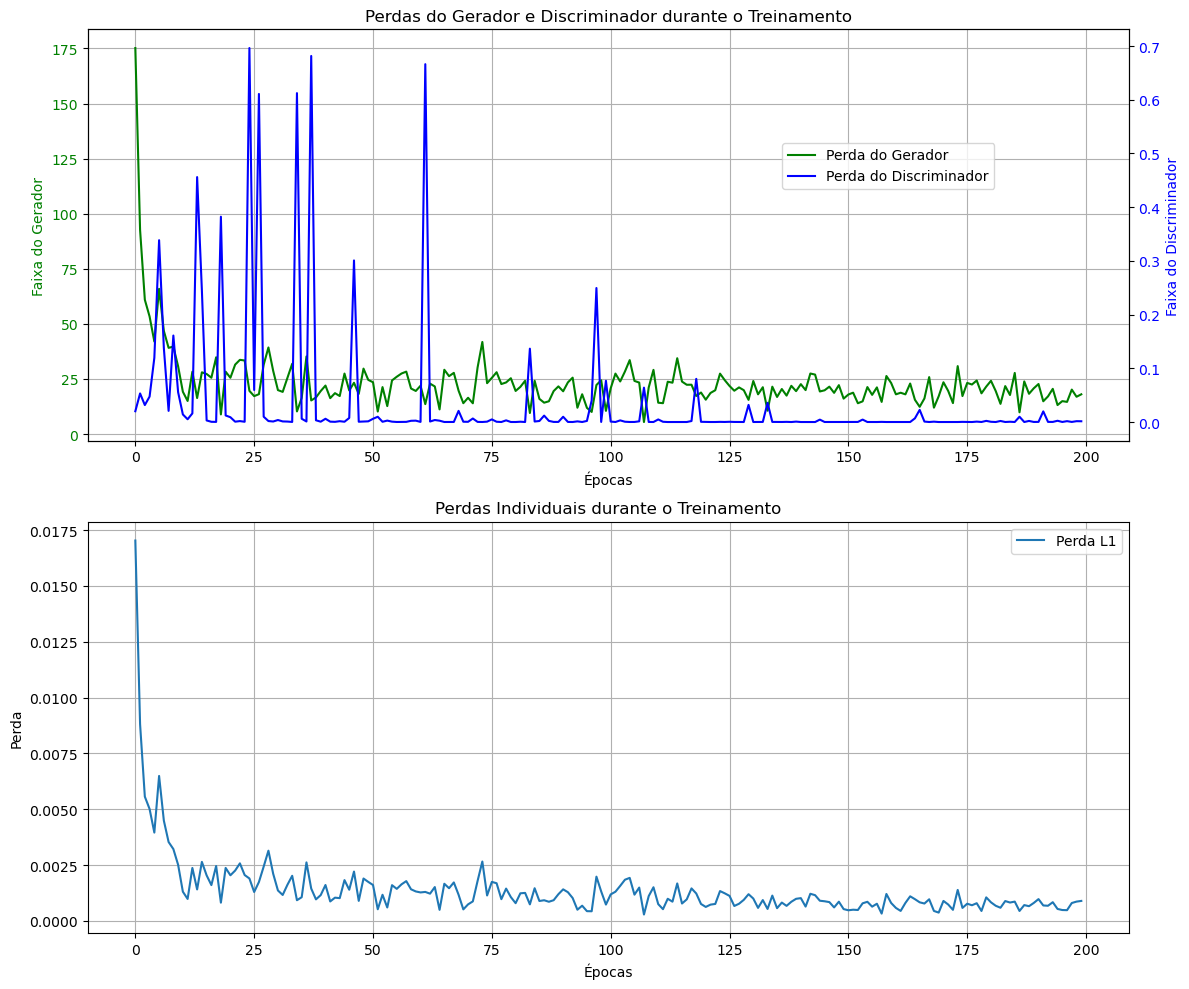

In [97]:
fig, (ax1, ax3) = plt.subplots(2,1, figsize=(12, 10))  # Definindo um layout de 1 linha e 2 colunas

# Primeiro gráfico: Perdas do Gerador e Discriminador
ax1.plot(G_losses, 'g-', label="Perda do Gerador")
ax1.set_xlabel("Épocas")
ax1.set_ylabel('Faixa do Gerador', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax2 = ax1.twinx()
ax2.plot(D_losses, 'b-', label="Perda do Discriminador")
ax2.set_ylabel('Faixa do Discriminador', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perdas do Gerador e Discriminador durante o Treinamento")
ax1.grid()
fig.legend(loc='upper left',  bbox_to_anchor=(0.65, 0.858))

# Segundo gráfico: Perdas Individuais durante o Treinamento
ax3.plot(L1_losses, label="Perda L1")
ax3.set_xlabel("Épocas")
ax3.set_ylabel("Perda")
ax3.set_title("Perdas Individuais durante o Treinamento")
ax3.grid()
ax3.legend()

# Salvando os gráficos
plt.tight_layout()  # Ajusta automaticamente o espaçamento
plt.savefig('pix2pix_P2VZ_combined.png')
plt.show()

In [39]:
torch.save({
    'generator_state_dict': G.state_dict(),
    'discriminator_state_dict': D.state_dict(),
    'generator_optimizer_state_dict': optimizer_G.state_dict(),
    'discriminator_optimizer_state_dict': optimizer_D.state_dict(),
    'epoch': epoch
}, 'pix2pix_P2VZcheckpoint.pth')

checkpoint = torch.load('pix2pix_P2VZcheckpoint.pth', weights_only=True)

G = GeneratorUnet(1) 
D = Discriminator(2) 

# Carregue o estado do gerador e discriminador
G.load_state_dict(checkpoint['generator_state_dict'])
D.load_state_dict(checkpoint['discriminator_state_dict'])

# Carregue os otimizadores
optimizer_G.load_state_dict(checkpoint['generator_optimizer_state_dict'])
optimizer_D.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])

if cuda:
    G = G.cuda()
    D = D.cuda()

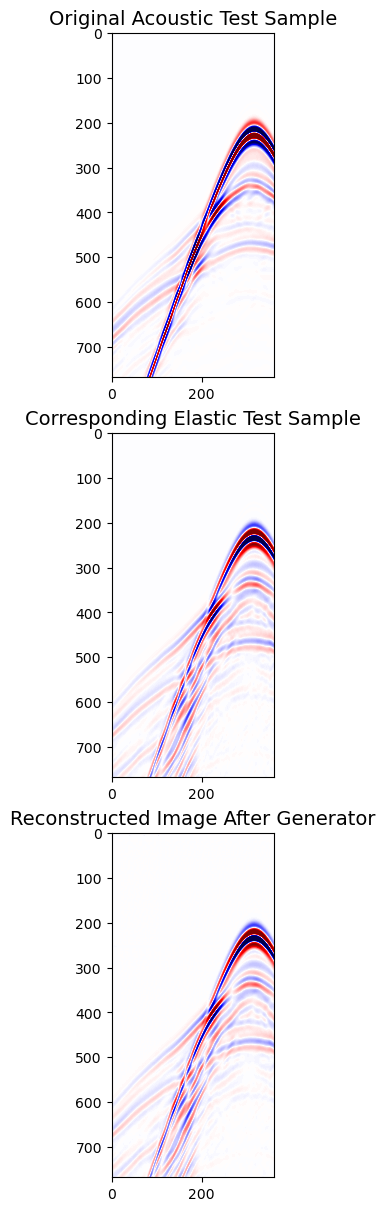

In [49]:
def split_into_patches(data, patch_size=256, vertical_overlap=0, horizontal_overlap=0):
    # Splitting 1024x768 matrices into 256x256 patches and storing their positions
    patches = []
    positions = []
    step_h = patch_size - horizontal_overlap
    step_v = patch_size - vertical_overlap
    for i in range(0, data.shape[0] - patch_size + 1, step_v):
        for j in range(0, data.shape[1] - patch_size + 1, step_h):
            patch = data[i:i+patch_size, j:j+patch_size]
            if patch.shape == (patch_size, patch_size):
                patches.append(patch)
                positions.append((i, j))  # Store positions as (row, col)
    return np.array(patches), positions

def reconstruct_from_patches(patches, positions, original_shape, patch_size=256):
    # Reconstruct the original image from patches using stored positions
    reconstructed = np.zeros(original_shape)

    for idx, (patch, (i, j)) in enumerate(zip(patches, positions)):
        # Se o patch ainda for um tensor PyTorch, desconecte-o do grafo computacional e converta para NumPy
        if isinstance(patch, torch.Tensor):
            patch = patch.detach().numpy()  # Detach and convert to NumPy array

        # Remova o canal extra (dimensão 1) se ele existir
        if patch.shape[-1] == 1:
            patch = np.squeeze(patch, axis=-1)
        
        # Coloque o patch de volta na posição original
        reconstructed[i:i+patch_size, j:j+patch_size] = patch

    return reconstructed

## Process the test data
for test_batch in test_dl:
    
    test_acustic, test_elastic = test_batch[0], test_batch[1]  # Assuming test_batch[0] is acoustic and test_batch[1] is elastic
    test_acustic = test_acustic.squeeze(0).squeeze(0)  # Remove batch dimension
    test_elastic = test_elastic.squeeze(0).squeeze(0)  # Remove batch dimension

    # Split acoustic test data into patches
    patches, positions = split_into_patches(test_acustic.numpy(), patch_size=256, vertical_overlap=0, horizontal_overlap=151)

    # Pass each acoustic patch through the generator G
    generated_patches = []
    for patch in patches:
        patch_tensor = torch.tensor(patch).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        patch_tensor = patch_tensor.to(device)  # Send to GPU if available
        generated_patch = G(patch_tensor)
        generated_patch = generated_patch.squeeze(0).cpu() 
        generated_patch = generated_patch.squeeze(0)
        generated_patches.append(generated_patch)

    # Reconstruct the image from the generated patches
    reconstructed_image = reconstruct_from_patches(generated_patches, positions, (768, 361), patch_size=256)

   # Definir o percentual
    perc = 99
    # Calcular os valores de vmax e vmin com base nos dados
    vmax = np.percentile(np.abs(test_acustic), perc)
    vmin = -vmax

    # Visualize the original acoustic, elastic, and reconstructed image
    plt.figure(figsize=(20, 12), constrained_layout=True)  # Increased width and layout spacing
    
    # Original Acoustic Test Sample
    plt.subplot(3, 1, 1)
    plt.title("Original Acoustic Test Sample", fontsize=14)
    plt.imshow(test_acustic, cmap='seismic', vmin=vmin, vmax=vmax)
    #plt.colorbar(fraction=0.046, pad=0.04)  # Adjust colorbar size and padding
    
    # Corresponding Elastic Test Sample
    plt.subplot(3, 1, 2)
    plt.title("Corresponding Elastic Test Sample", fontsize=14)
    plt.imshow(test_elastic, cmap='seismic', vmin=vmin, vmax=vmax)
    #plt.colorbar(fraction=0.046, pad=0.04)
    
    # Reconstructed Image After Generator
    plt.subplot(3, 1, 3)
    plt.title("Reconstructed Image After Generator", fontsize=14)
    plt.imshow(reconstructed_image, cmap='seismic', vmin=vmin, vmax=vmax)
    #plt.colorbar(fraction=0.046, pad=0.04)

    plt.savefig('Acoustic P to Elastic Vz (Pós-treino)', bbox_inches='tight')
    plt.show()
    break  # Process only one batch for visualization